In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

if torch.cuda.is_available():
    print("GPU is available")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(0) / 1024**2} MB")
    print(f"GPU Memory Cached: {torch.cuda.memory_reserved(0) / 1024**2} MB")
else:
    print("GPU is not available")

cpu
GPU is not available


In [3]:

# Load dataset
df = pd.read_csv('/Users/merinmoby/Desktop/mental health/depression_dataset_reddit_cleaned.csv')

In [4]:
# Preprocessing
X = df['clean_text'].tolist()
y = df['is_depression'].tolist()


In [5]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [6]:

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [7]:
# Define a Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=100):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors="pt"
        )
        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)
        label = torch.tensor(self.labels[idx], dtype=torch.float)
        return input_ids, attention_mask, label

In [8]:
# Create DataLoaders
train_dataset = TextDataset(X_train, y_train, tokenizer)
test_dataset = TextDataset(X_test, y_test, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [9]:
# Define BERT + LSTM Model
class BertLSTMClassifier(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased', lstm_hidden_size=128, num_classes=1):
        super(BertLSTMClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.lstm = nn.LSTM(input_size=768, hidden_size=lstm_hidden_size,
                            batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(lstm_hidden_size * 2, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():  # Freeze BERT during training
            bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            hidden_states = bert_output.last_hidden_state  # Shape: (batch_size, seq_length, 768)
        
        lstm_out, _ = self.lstm(hidden_states)  # Shape: (batch_size, seq_length, hidden_size*2)
        lstm_out = self.dropout(lstm_out[:, -1, :])  # Use last LSTM output
        output = self.fc(lstm_out)
        return self.sigmoid(output).squeeze()


In [10]:
# Initialize model
model = BertLSTMClassifier().to(device)

In [11]:
# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)

# Training loop
def train_model(model, train_loader, criterion, optimizer, device, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for input_ids, attention_mask, labels in train_loader:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

train_model(model, train_loader, criterion, optimizer, device)


Epoch 1, Loss: 0.6026
Epoch 2, Loss: 0.4493
Epoch 3, Loss: 0.2728


In [12]:
# Evaluate the model
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for input_ids, attention_mask, labels in test_loader:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            outputs = model(input_ids, attention_mask)
            preds = (outputs > 0.5).int()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Classification Report:\n", classification_report(all_labels, all_preds))
    return all_labels, all_preds

all_labels, all_preds=evaluate_model(model, test_loader, device)

Accuracy: 0.9276
F1 Score: 0.9246
Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.96      0.93       780
         1.0       0.96      0.90      0.92       767

    accuracy                           0.93      1547
   macro avg       0.93      0.93      0.93      1547
weighted avg       0.93      0.93      0.93      1547



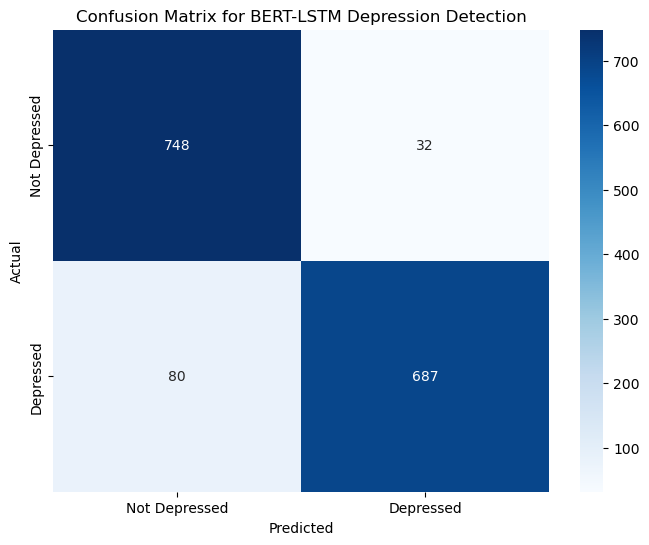

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
cm=confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for BERT-LSTM Depression Detection")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0.5,1.5],["Not Depressed","Depressed"])
plt.yticks([0.5,1.5],["Not Depressed","Depressed"])
plt.show()


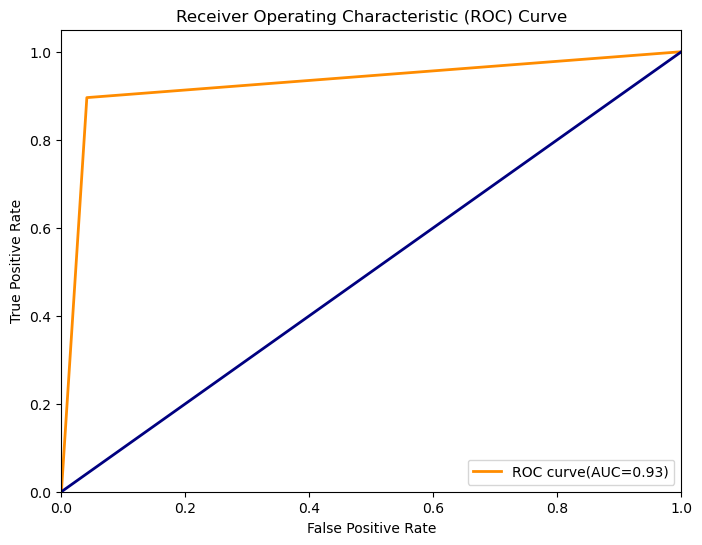

In [14]:
from sklearn.metrics import roc_curve, auc
fpr, tpr,_=roc_curve(all_labels, all_preds)
roc_auc=auc(fpr,tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr,tpr,color="darkorange", lw=2, label=f'ROC curve(AUC={roc_auc:.2f})')
plt.plot([0,1], [0,1],color="navy", lw=2, linestyle="-")
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()





In [15]:

from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []  # <--- Collect predicted probabilities

    with torch.no_grad():
        for input_ids, attention_mask, labels in test_loader:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            outputs = model(input_ids, attention_mask)
            preds = (outputs > 0.5).int()

            all_probs.extend(outputs.cpu().numpy())  # <--- Collect raw probs
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Classification Report:\n", classification_report(all_labels, all_preds))
    
    return all_labels, all_preds, all_probs


In [16]:
all_labels, all_preds, all_probs = evaluate_model(model, test_loader, device)


Accuracy: 0.9276
F1 Score: 0.9246
Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.96      0.93       780
         1.0       0.96      0.90      0.92       767

    accuracy                           0.93      1547
   macro avg       0.93      0.93      0.93      1547
weighted avg       0.93      0.93      0.93      1547



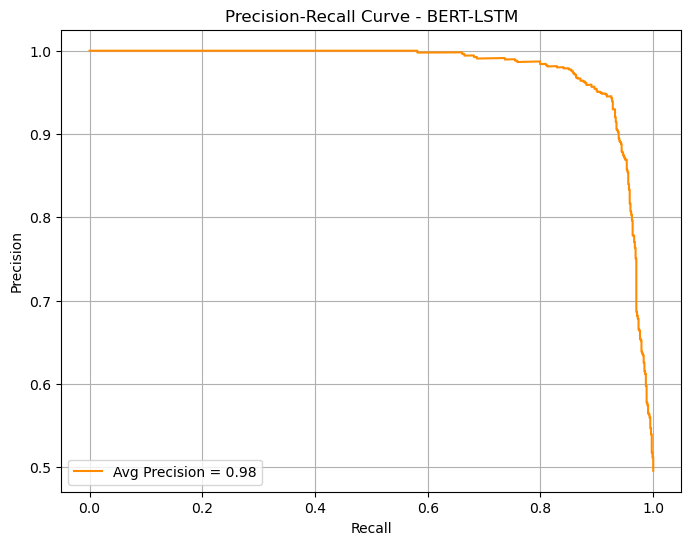

In [17]:
# Convert to numpy arrays (just to be safe)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Calculate Precision, Recall and Average Precision
precision, recall, thresholds = precision_recall_curve(all_labels, all_probs)
avg_precision = average_precision_score(all_labels, all_probs)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"Avg Precision = {avg_precision:.2f}", color='darkorange')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - BERT-LSTM")
plt.legend()
plt.grid(True)
plt.show()


Accuracy: 0.8888
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.80      0.88       783
           1       0.83      0.98      0.90       764

    accuracy                           0.89      1547
   macro avg       0.90      0.89      0.89      1547
weighted avg       0.90      0.89      0.89      1547



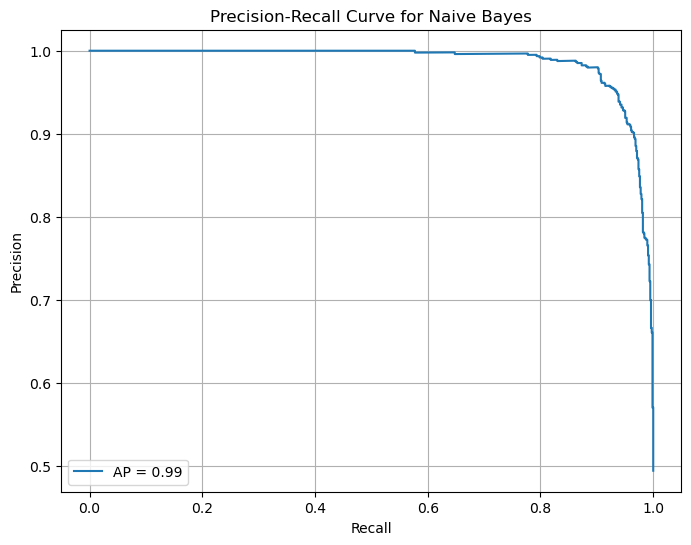

In [47]:
#naive bayes
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pandas as pd

# Load dataset
df = pd.read_csv('depression_dataset_reddit_cleaned.csv')

# Extract features and labels
X = df['clean_text']
y = df['is_depression']

# Convert text data to numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Limit features for efficiency
X_tfidf = vectorizer.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

from sklearn.naive_bayes import MultinomialNB

# Initialize and train the Naive Bayes model
model = MultinomialNB()
model.fit(X_train, y_train)

from sklearn.metrics import accuracy_score, classification_report

# Predict on test data
y_pred = model.predict(X_test)

# Calculate accuracy and report classification metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class (class 1)
y_scores = model.predict_proba(X_test)[:, 1]

# Compute precision-recall pairs for different probability thresholds
precision_nb, recall_nb, thresholds_nb = precision_recall_curve(y_test, y_scores)

# Compute average precision score
average_precision_nb = average_precision_score(y_test, y_scores)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall_nb, precision_nb, label=f'AP = {average_precision_nb:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Naive Bayes')
plt.legend()
plt.grid(True)
plt.show()


Accuracy: 0.5650
Classification Report:
               precision    recall  f1-score   support

           0       0.54      1.00      0.70       780
           1       0.98      0.13      0.22       767

    accuracy                           0.56      1547
   macro avg       0.76      0.56      0.46      1547
weighted avg       0.76      0.56      0.46      1547



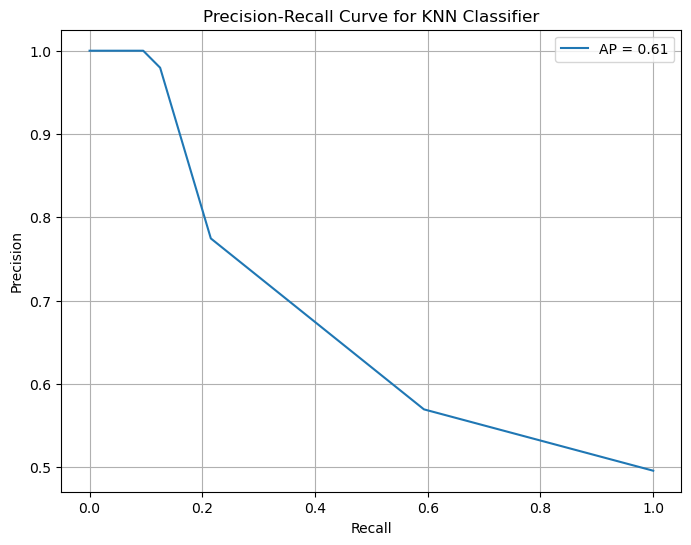

In [51]:
#knn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pandas as pd

# Load dataset
df = pd.read_csv('depression_dataset_reddit_cleaned.csv')

# Extract features and labels
X = df['clean_text']
y = df['is_depression']

# Convert text data to numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Limit features for efficiency
X_tfidf = vectorizer.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, stratify=y, random_state=42)

from sklearn.neighbors import KNeighborsClassifier

# Initialize and train the KNN model
model = KNeighborsClassifier(n_neighbors=5)  # You can adjust 'n_neighbors' for optimal performance
model.fit(X_train, y_train)

from sklearn.metrics import accuracy_score, classification_report

# Predict on test data
y_pred = model.predict(X_test)

# Calculate accuracy and report classification metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class (class 1)
y_scores = model.predict_proba(X_test)[:, 1]

# Compute precision-recall pairs for different probability thresholds
precision_kn, recall_kn, thresholds_kn = precision_recall_curve(y_test, y_scores)

# Compute average precision score
average_precision_kn = average_precision_score(y_test, y_scores)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall_kn, precision_kn, label=f'AP = {average_precision_kn:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for KNN Classifier')
plt.legend()
plt.grid(True)
plt.show()


Accuracy: 0.9160
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92       780
           1       0.92      0.91      0.91       767

    accuracy                           0.92      1547
   macro avg       0.92      0.92      0.92      1547
weighted avg       0.92      0.92      0.92      1547



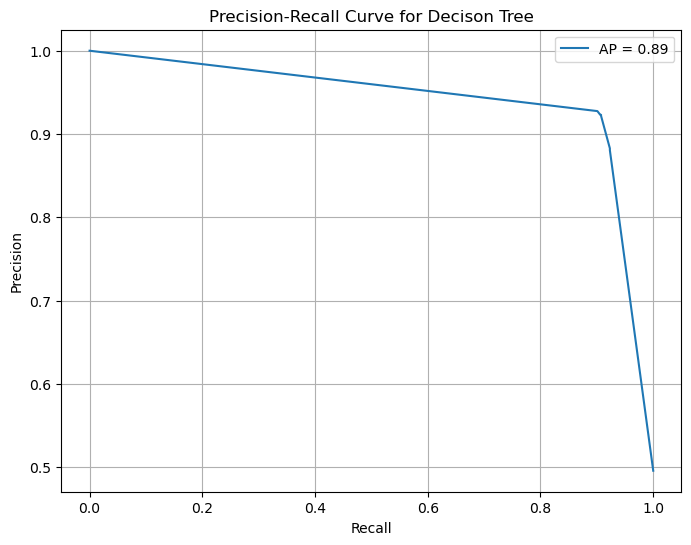

In [49]:
# decision tree
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pandas as pd

# Load dataset
df = pd.read_csv('depression_dataset_reddit_cleaned.csv')

# Extract features and labels
X = df['clean_text']
y = df['is_depression']

# Convert text data to numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=100)  # Limit features for efficiency
X_tfidf = vectorizer.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, stratify=y, random_state=42)

from sklearn.tree import DecisionTreeClassifier

# Initialize and train the Decision Tree model
model = DecisionTreeClassifier(criterion='gini', max_depth=None, random_state=42)
model.fit(X_train, y_train)
from sklearn.metrics import accuracy_score, classification_report

# Predict on test data
y_pred = model.predict(X_test)

# Calculate accuracy and report classification metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class (class 1)
y_scores = model.predict_proba(X_test)[:, 1]

# Compute precision-recall pairs for different probability thresholds
precision_dt, recall_dt, thresholds_dt = precision_recall_curve(y_test, y_scores)

# Compute average precision score
average_precision_dt = average_precision_score(y_test, y_scores)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall_dt, precision_dt, label=f'AP = {average_precision_dt:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Decison Tree')
plt.legend()
plt.grid(True)
plt.show()

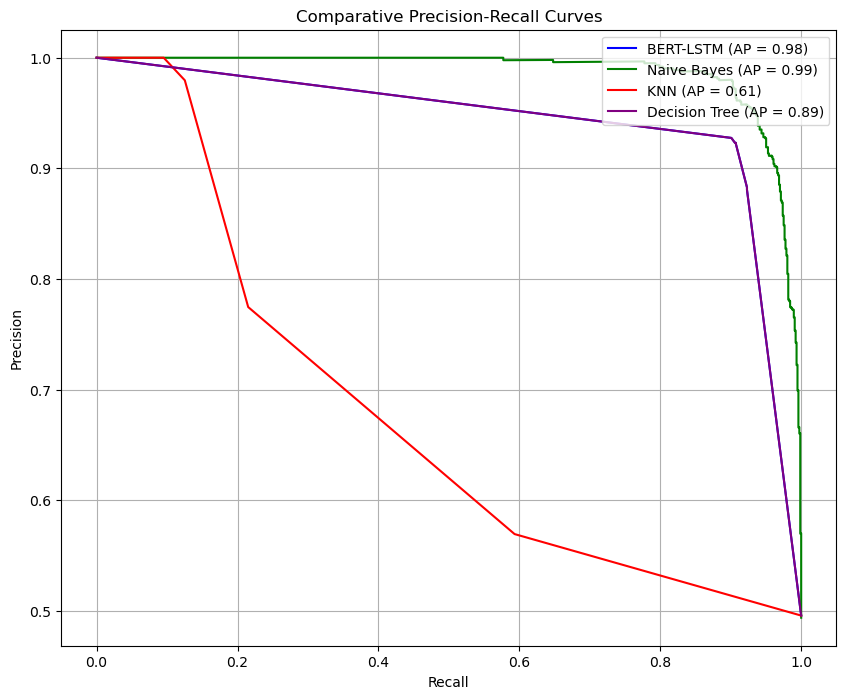

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

# Plot BERT-LSTM curve (from previous execution)
plt.plot(recall, precision, label=f'BERT-LSTM (AP = {avg_precision:.2f})', color='blue')

# Plot Naive Bayes curve (from NB section)
plt.plot(recall_nb, precision_nb, label=f'Naive Bayes (AP = {average_precision_nb:.2f})', color='green')

# Plot KNN curve (from KNN section)
plt.plot(recall_kn, precision_kn, label=f'KNN (AP = {average_precision_kn:.2f})', color='red')

# Plot Decision Tree curve (from DT section)
plt.plot(recall_dt, precision_dt, label=f'Decision Tree (AP = {average_precision_dt:.2f})', color='purple')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Comparative Precision-Recall Curves')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()
